## Pedro Daia Cardoso

Neste notebook, vamos abordar dois diferentes problemas de Computer Vision:


*   Multi-Label Classification: quando queremos classificar mais de uma label (ou nenhuma) por imagem
*   Regression: quando as labels são quantidades e não categorias (1 ou vários digitos numericos)



In [3]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

Mounted at /content/gdrive


Primeiramente, vamos ver os dados que vamos trabalhar. Um exemplo de um multi-label dataset seria a PASCAL.

In [4]:
path = untar_data(URLs.PASCAL_2007)
Path.BASE_PATH = path
path.ls()

(#8) [Path('segmentation'),Path('train.csv'),Path('train'),Path('test.json'),Path('valid.json'),Path('test.csv'),Path('train.json'),Path('test')]

In [6]:
(path/'train').ls()

(#5012) [Path('train/007601.jpg'),Path('train/007163.jpg'),Path('train/002233.jpg'),Path('train/009342.jpg'),Path('train/005590.jpg'),Path('train/004562.jpg'),Path('train/002291.jpg'),Path('train/005327.jpg'),Path('train/007570.jpg'),Path('train/006661.jpg')...]

Vamos ler o .csv dos arquivos de treinamento, para isso vamos utilizar a biblioteca Pandas.



In [8]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Vamos agora criar nosso DataLoader com base nesse dataset.
Antes, relembrar as classes do PyToch e fastai que utilizamos para isso.

Para representar e acessar training e validation sets, temos:

*   Dataset: uma collection que retorna um tuple das suas variáveis dependentes e independentes para um único item.
*   DataLoader: um iterador que providencia uma série de mini batches, onde cada minibatch é um conjunto de váriaveis dependentes e independentes.

Além disso o fastai providencia, para juntar training e validation sets:


*   Datasets: iterador que contém um training Dataset e um validation Dataset
*   DataLoaders: objeto que contém um training DataLoader e um validation DataLoader





In [23]:
def getName(r): 
  return path/'train'/r['fname'] # inves de somente r[fname], precisamos da path completa para abrir as imagens.

def getLabel(r): 
  return r['labels'].split(' ') # split no espaco para pegar duas labels separadas, ex: horse person vira (horse), (person)

dblock = DataBlock(get_x = getName, get_y = getLabel)

dsets = dblock.datasets(df)

dsets.train[0]

(Path('train/005248.jpg'), ['person', 'horse'])

Para de fato trabalhar com as imagens e converter para tensores, precisamos usar os tranforms. ImageBlock funcionará para as imagens em si, pois já temos uma path apontando para uma img válida. Porém, utilizar o CategoryBlock não funcionará pois podemos ter várias labels em uma só imagem. Para isso, vamos usar o MultiCategoryBlock:

In [26]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x = getName, get_y = getLabel)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Com o MultiCategoryBlock, temos uma lista de 0s, com 1s em cada posicão onde uma categoria está presente. Isso também é conhecido como *one-hot encoding*.
Verificar o que as categorias no exemplo do índice [0] acima representa:

In [27]:
indexes = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[indexes]

(#1) ['car']

Para escolhermos não aleatoriamente os elementos do nosso validation set, precisamos criar uma funcão splitter

In [30]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter, get_x = getName, get_y = getLabel)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Agora que já conseguimos criar um DataSet correto, para poder criar o DataLoader, devemos ter certeza que todos os itens são do mesmo tamanho, usando o RandomResizedCrop.

Vamos então criar o DataLoaders desses datasets corretos:

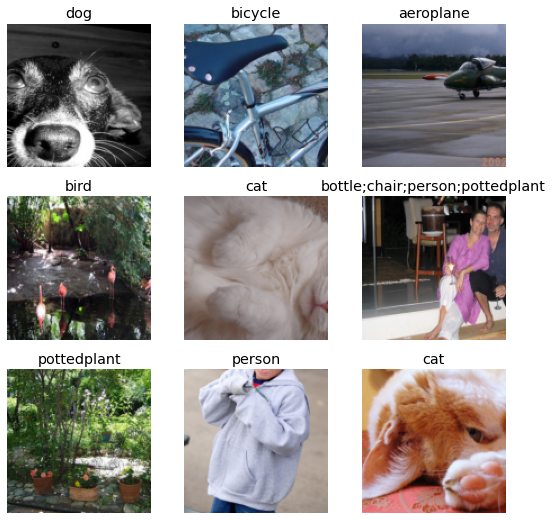

In [31]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter, get_x = getName, get_y = getLabel,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

dls.show_batch()